# **Anomaly Detection - RESNET AE Experiment 7**

### Imports

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, ConfusionMatrixDisplay)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Dataset 

In [2]:
# Paths to audio files
anomalous_audio_path = "../Data/raw/11_A_09_experiment7/A_09_10_experiment7_8.wav"
normal_audio_path = "../Data/raw/11_A_09_experiment7/N_09_experiment7.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../Data/frames/anomalous_frames.npy"
output_normal_frames_path = "../Data/frames/normal_frames.npy"
train_frames_path = "../Data/datasets/train_frames.npy"
val_frames_path = "../Data/datasets/val_frames.npy"
test_frames_path = "../Data/datasets/test_frames.npy"
test_labels_path = "../Data/datasets/test_labels.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)

# 1. Data Preprocessing

### Mel-Spectrogram Generation

In [3]:
# Fixed parameters to ensure correct dimensions
sr = 16000
hop_length = 512
time_per_frame = 0.512  # Ensures frame_size = 16
hop_ratio = 0.2

frame_size = int((time_per_frame * sr) / hop_length)  # Should be 16
hop_size = int(frame_size * hop_ratio)  # e.g., 16*0.2=3

In [4]:
def generate_mel_spectrogram(audio_path, sr=16000):
    audio, sr = librosa.load(audio_path, sr=sr)
    stft = librosa.stft(audio, n_fft=1024, hop_length=hop_length)
    mel = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

### Frame Generation

In [5]:
# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

def plot_frames(frames, num_frames=5, title_prefix="Frame"):
    num_frames = min(num_frames, len(frames))
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        ax = axes[i] if num_frames > 1 else axes
        librosa.display.specshow(frames[i], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Visualizing frames for anomalous sounds...


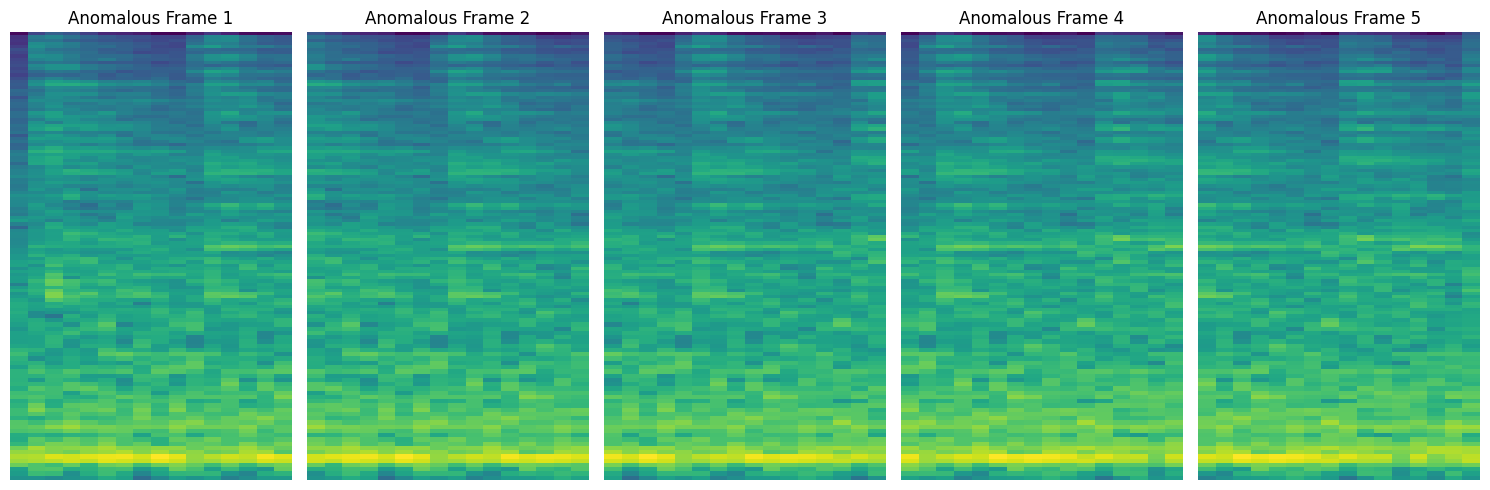

Visualizing frames for normal sounds...


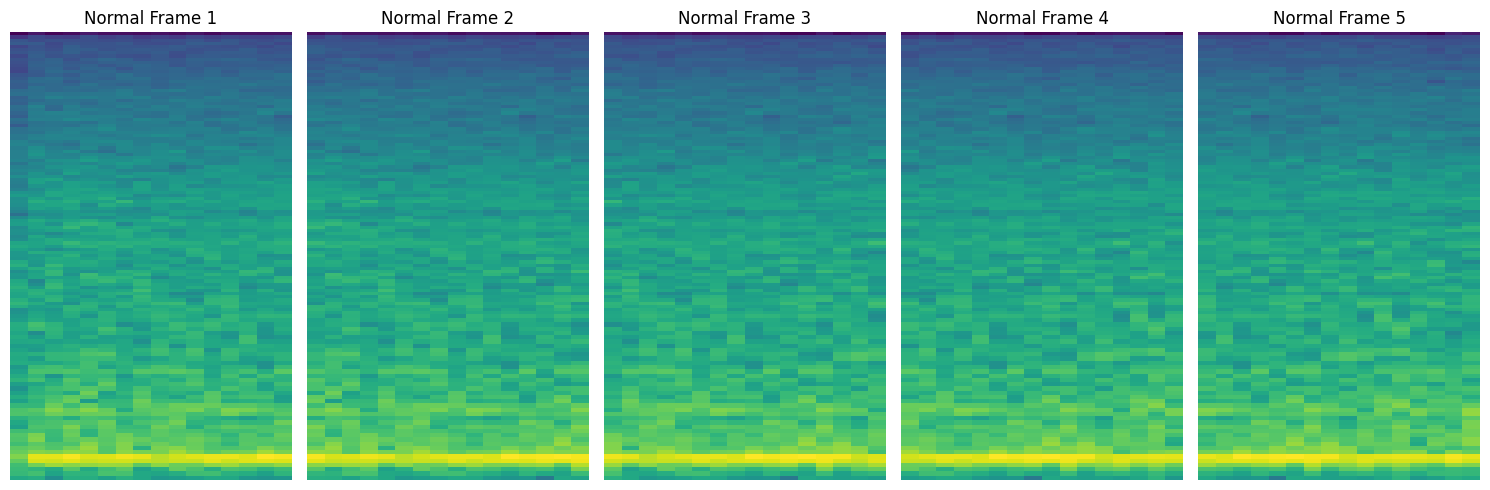

In [6]:
# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path, sr=sr)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path, sr=sr)
assert sr_anomalous == sr_normal, "Sampling rates do not match!"

# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

print("Visualizing frames for anomalous sounds...")
plot_frames(anomalous_frames, num_frames=5, title_prefix="Anomalous Frame")

print("Visualizing frames for normal sounds...")
plot_frames(normal_frames, num_frames=5, title_prefix="Normal Frame")

# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)


### Train and Test Splitting

In [7]:
# Load frames
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

# Split data
normal_train_val, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.1765, random_state=42)

test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(val_frames_path, normal_val)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)

# Prepare for PyTorch
train_frames = np.load(train_frames_path)
val_frames = np.load(val_frames_path)

train_frames_tensor = torch.tensor(train_frames, dtype=torch.float32).unsqueeze(1)
val_frames_tensor = torch.tensor(val_frames, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(train_frames_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(val_frames_tensor), batch_size=64)

# 2. Autoencoder Model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128,16) -> (64,8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # (64,8) -> (32,4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # (32,4) -> (16,2)
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # (16,2)->(32,4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # (32,4)->(64,8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64,8)->(128,16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),  # (128,16)->(128,16)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 3. Training

In [9]:
# Select device (MPS if available, else CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device selected.")
else:
    device = torch.device("cpu")
    print("MPS not available. CPU device selected.")

MPS device selected.


Epoch 1/10, Training Loss: 0.0025, Validation Loss: 0.0012
Epoch 2/10, Training Loss: 0.0010, Validation Loss: 0.0008
Epoch 3/10, Training Loss: 0.0007, Validation Loss: 0.0006
Epoch 4/10, Training Loss: 0.0005, Validation Loss: 0.0004
Epoch 5/10, Training Loss: 0.0004, Validation Loss: 0.0003
Epoch 6/10, Training Loss: 0.0003, Validation Loss: 0.0003
Epoch 7/10, Training Loss: 0.0003, Validation Loss: 0.0002
Epoch 8/10, Training Loss: 0.0002, Validation Loss: 0.0002
Epoch 9/10, Training Loss: 0.0002, Validation Loss: 0.0002
Epoch 10/10, Training Loss: 0.0002, Validation Loss: 0.0002


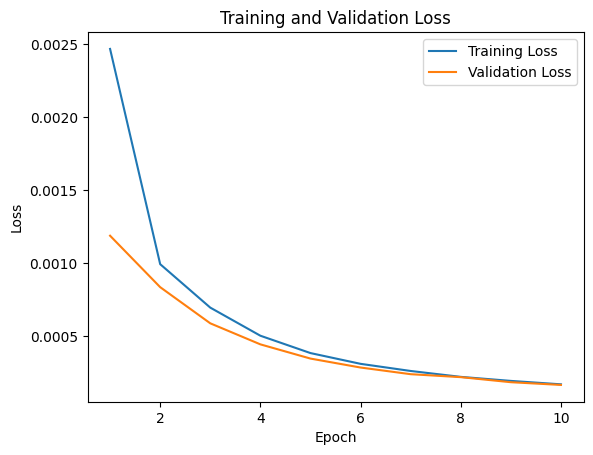

Autoencoder model saved to autoencoder_model.pth


In [10]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

torch.save(autoencoder.state_dict(), "autoencoder_model.pth")
print("Autoencoder model saved to autoencoder_model.pth")

# 4. Anomalie Detection

### Threshold Setting

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device selected for inference.")
else:
    device = torch.device("cpu")
    print("MPS not available. CPU device selected for inference.")

# Load test frames and labels
test_frames = np.load(test_frames_path)
test_labels = np.load(test_labels_path)

# Convert test frames to PyTorch tensor and move to device
test_frames_tensor = torch.tensor(test_frames, dtype=torch.float32).unsqueeze(1).to(device)

# Make sure val_frames_tensor exists on device as well (from previous code snippet)
val_frames_tensor = val_frames_tensor.to(device)

# Load the trained autoencoder model and move to device
autoencoder.load_state_dict(torch.load("autoencoder_model.pth", map_location=device))
autoencoder.to(device)
autoencoder.eval()

# Compute reconstruction errors on the validation set
with torch.no_grad():
    val_reconstructions = autoencoder(val_frames_tensor)
    val_losses_tensor = nn.functional.mse_loss(val_reconstructions, val_frames_tensor, reduction='none')
    val_losses = val_losses_tensor.view(val_losses_tensor.size(0), -1).mean(dim=1).cpu().numpy()  # Move back to CPU for numpy

# Set threshold based on validation losses (e.g., top 4%)
threshold = np.percentile(val_losses, 96)
print(f"Threshold for anomaly detection set at: {threshold}")

# Compute reconstruction errors on the test set
with torch.no_grad():
    test_reconstructions = autoencoder(test_frames_tensor)
    test_losses_tensor = nn.functional.mse_loss(test_reconstructions, test_frames_tensor, reduction='none')
    test_losses = test_losses_tensor.view(test_losses_tensor.size(0), -1).mean(dim=1).cpu().numpy()  # Move back to CPU


MPS device selected for inference.


/var/folders/rh/swfvk_zs36s3zmd3j2nmq0kw0000gn/T/ipykernel_1681/2100753475.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("autoe

Threshold for anomaly detection set at: 0.00018495388212613761


### Anomaly Prediction

In [12]:
# Predict anomalies
predictions = (test_losses > threshold).astype(int)

### Evaluation

ROC AUC Score: 0.9984
Precision: 0.9774, Recall: 0.9931, F1-Score: 0.9852
Confusion Matrix:
[[1148   50]
 [  15 2163]]


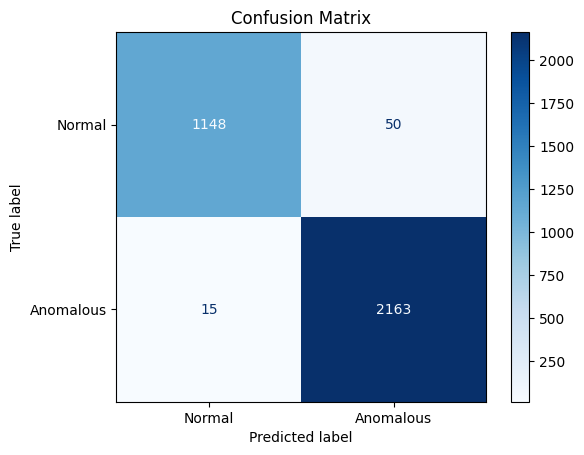

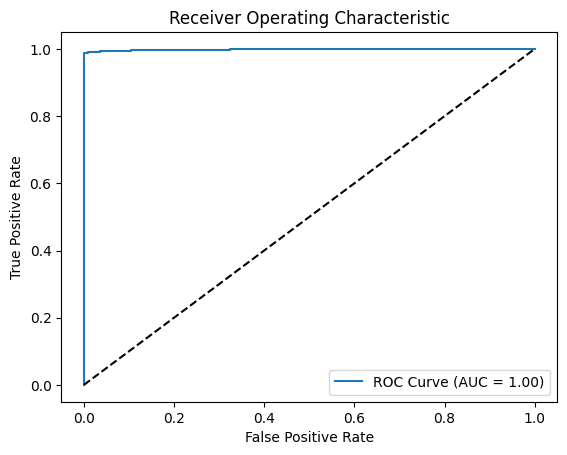

In [13]:
# Evaluate performance
roc_auc = roc_auc_score(test_labels, test_losses)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')
conf_matrix = confusion_matrix(test_labels, predictions)

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_losses)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Correctly Classified Anomalies:


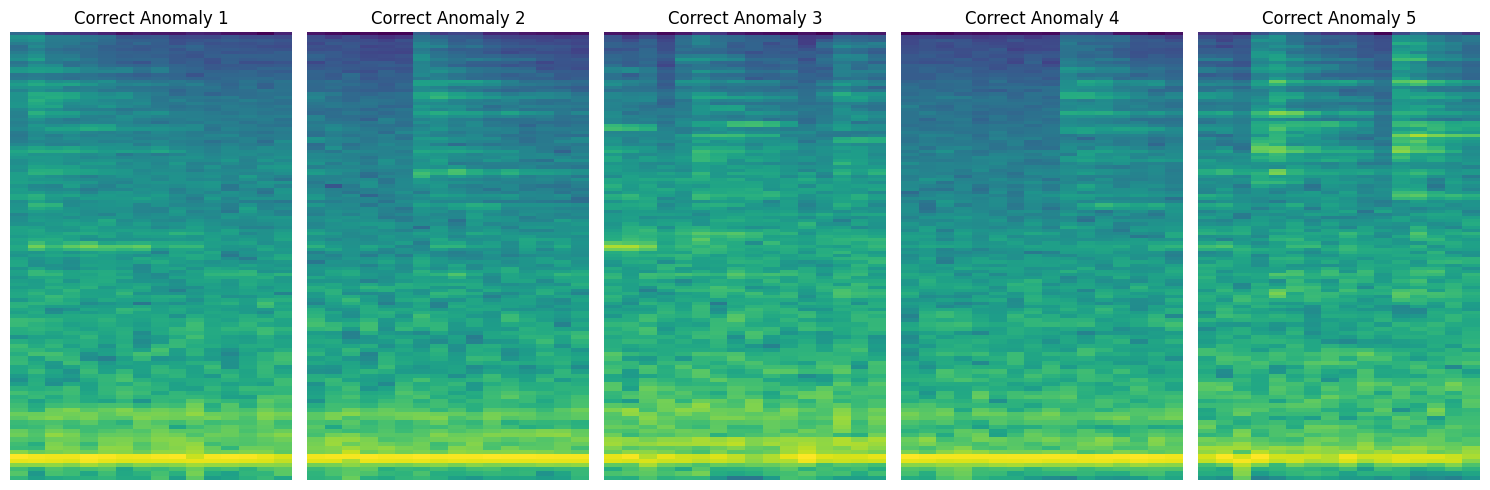

Wrongly Classified Anomalies:


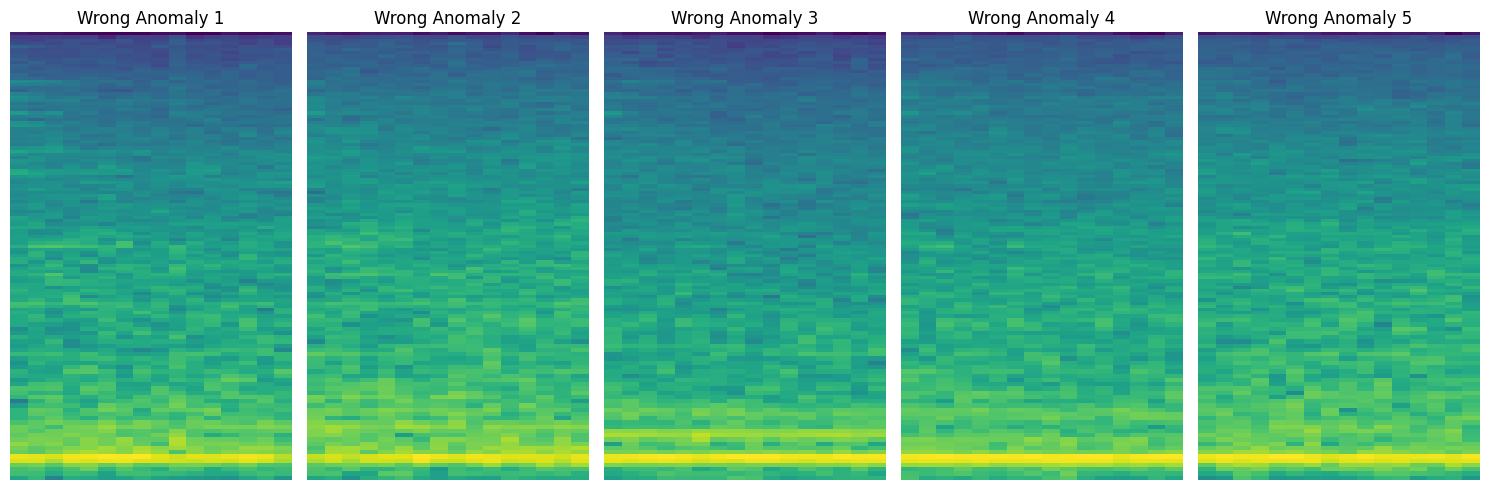

Wrongly Classified Normal Frames:


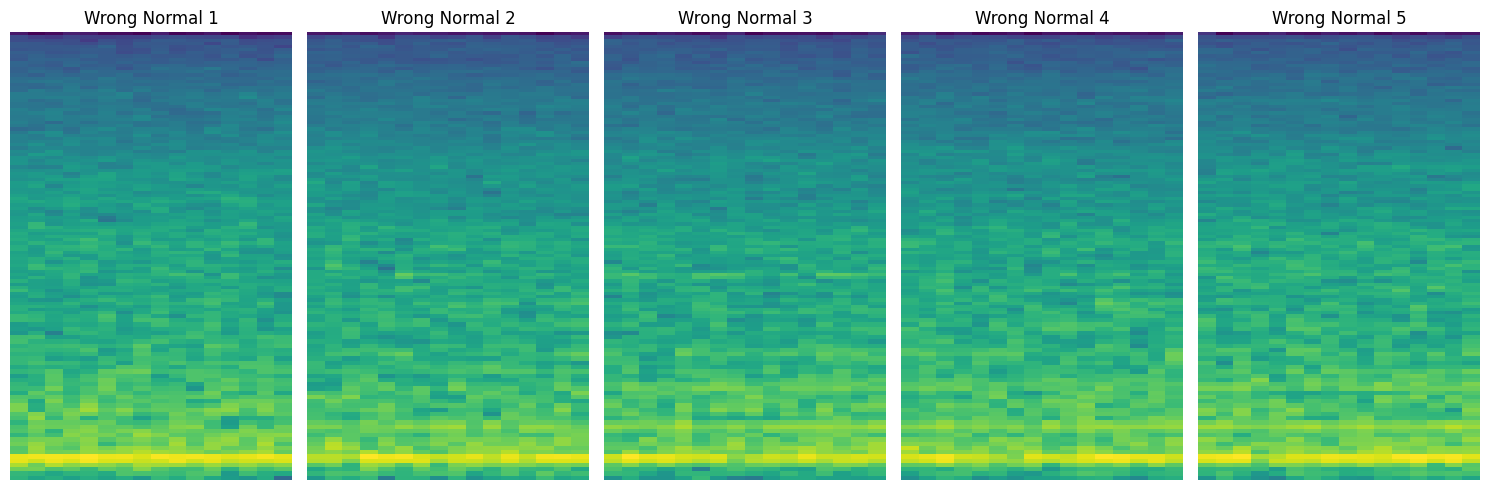

In [14]:
# Identify indices
correctly_classified_anomalies = np.where((test_labels == 1) & (predictions == 1))[0]
wrongly_classified_anomalies = np.where((test_labels == 1) & (predictions == 0))[0]
wrongly_classified_normals = np.where((test_labels == 0) & (predictions == 1))[0]

# Select up to 5 samples from each category
num_samples = 5
correct_anomaly_indices = correctly_classified_anomalies[:num_samples]
wrong_anomaly_indices = wrongly_classified_anomalies[:num_samples]
wrong_normal_indices = wrongly_classified_normals[:num_samples]

# Function to plot specified frames
def plot_specified_frames(frames, indices, title_prefix="Frame"):
    num_frames = len(indices)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i, idx in enumerate(indices):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[idx], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Plot 5 correctly classified anomalies
print("Correctly Classified Anomalies:")
plot_specified_frames(test_frames, correct_anomaly_indices, title_prefix="Correct Anomaly")

# Plot 5 wrongly classified anomalies
print("Wrongly Classified Anomalies:")
plot_specified_frames(test_frames, wrong_anomaly_indices, title_prefix="Wrong Anomaly")

# Plot 5 wrongly classified normal frames
print("Wrongly Classified Normal Frames:")
plot_specified_frames(test_frames, wrong_normal_indices, title_prefix="Wrong Normal")

In [15]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt
from matplotlib import ticker

import librosa.display
import numpy as np
import os

## **1. Loading MEL Scales**

1.1. 10_experiment8_5tesMic_Schaufel_rumlaufen

In [16]:
# Paths to your audio files in the aligned folder
audio_exp8_path = "../Data/raw/11_A_09_experiment7/A_09_10_experiment7_8.wav"

# Load aligned audio files
audio_knock, sr1 = librosa.load(audio_exp8_path, sr=None)
print("audio_exp8 loaded.")

audio_exp8 loaded.


In [17]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_knock = librosa.stft(audio_knock, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [18]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_knock = librosa.feature.melspectrogram(S=np.abs(stft_knock), sr=sr1, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_knock = librosa.power_to_db(mel_knock, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_knock = (mel_db_knock - np.mean(mel_db_knock)) / np.std(mel_db_knock)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/A_09_10_experiment7_8.npy", mel_db_knock)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


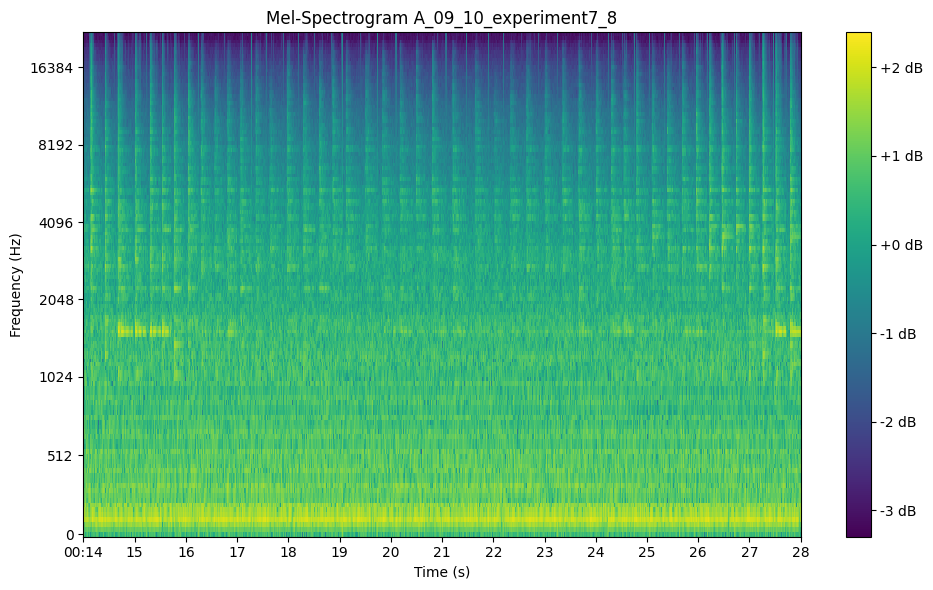

In [19]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram A_09_10_experiment7_8', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_A_09_10_experiment7_8.png')
plt.show()

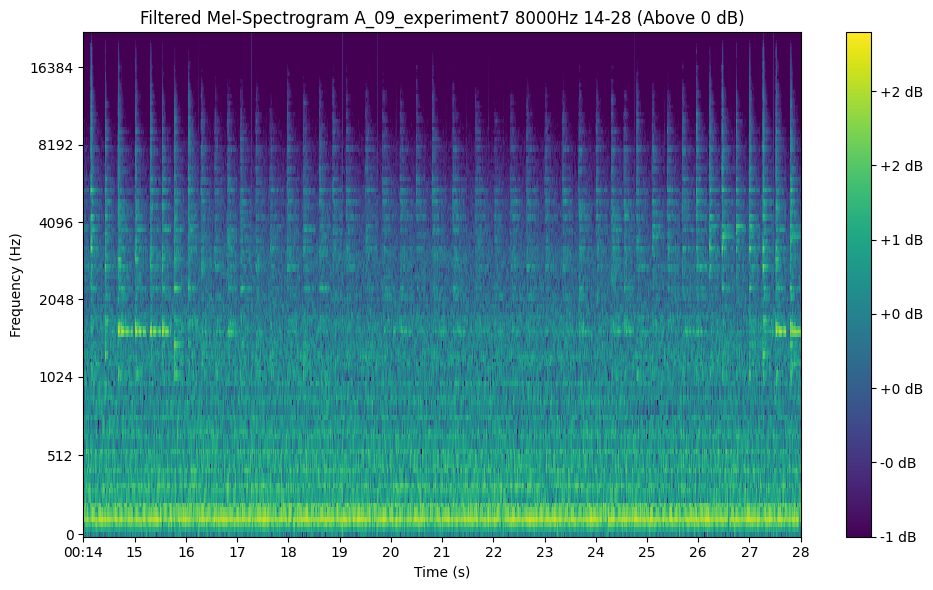

In [20]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax, vmin=-1)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram A_09_experiment7 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([14, 28])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img2, ax=ax, format='%+2.0f dB')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_A_09_10_experiment7_8_8000_filtered.png')
plt.show()

### Frames


In [21]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]

    return frames

# Generate frames for anomalous Pi1 and Pi2
frames_Api1 = generate_frames(mel_db_knock)

print(f"Frames Api1 (Anomalous): {frames_Api1.shape}")


Frames Api1 (Anomalous): (280, 128, 128)


1.2. 08_livetest_knackgeräusch_output_MIC3

In [22]:
# Paths to your audio files in the aligned folder
audio_knock_path = "../Data/raw/08_livetest_knackgeräusch/output_MIC3_2024-11-07_13-55-04_968247.wav"

# Load aligned audio files
audio_knock, sr1 = librosa.load(audio_knock_path, sr=None)
print("audio_knock loaded.")

audio_knock loaded.


In [23]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_knock = librosa.stft(audio_knock, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [24]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_knock = librosa.feature.melspectrogram(S=np.abs(stft_knock), sr=sr1, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_knock = librosa.power_to_db(mel_knock, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_knock = (mel_db_knock - np.mean(mel_db_knock)) / np.std(mel_db_knock)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_knock.npy", mel_db_knock)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


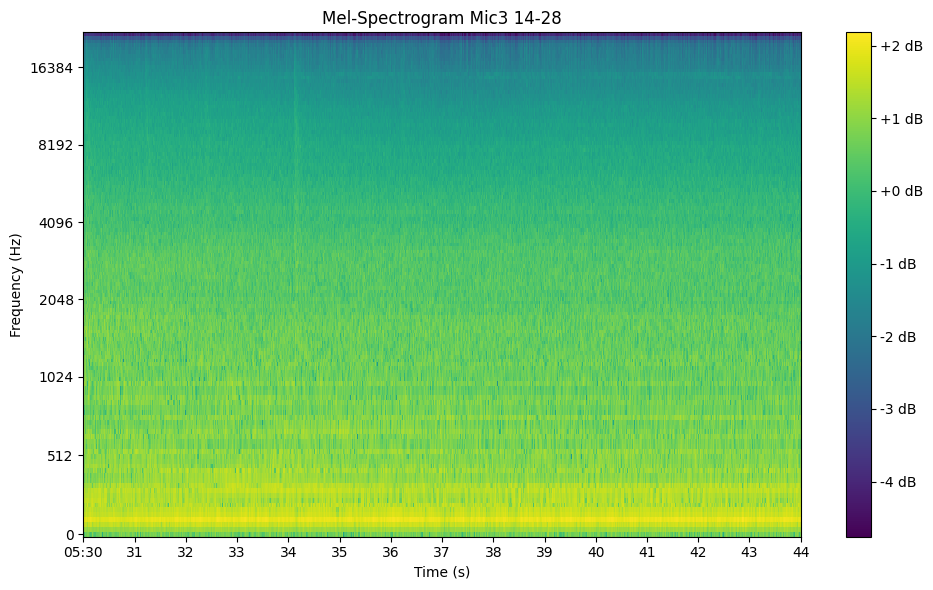

In [25]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Mic3 14-28', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([330, 344])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_8.png')
plt.show()

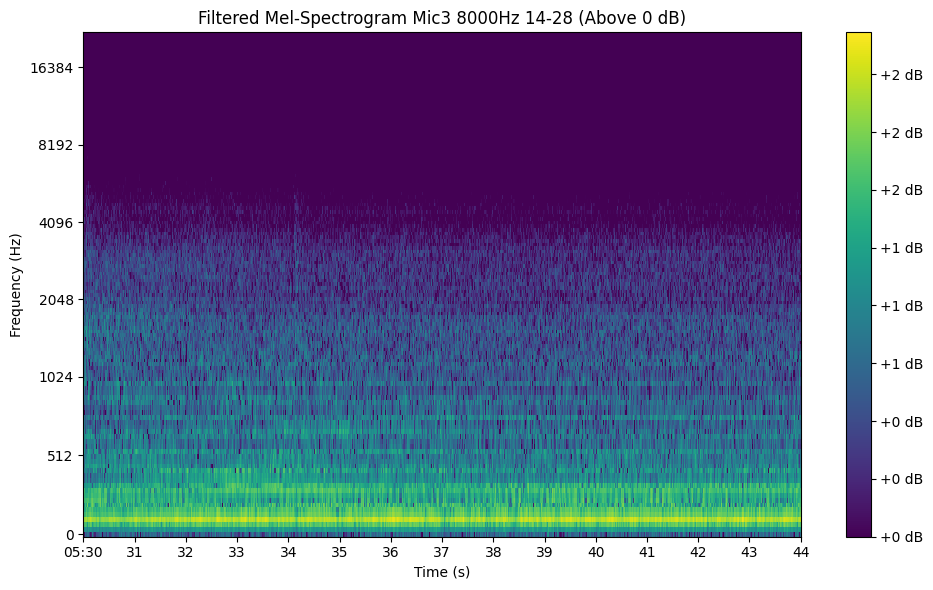

In [26]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax, vmin=0)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram Mic3 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([330, 344])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img2, ax=ax, format='%+2.0f dB')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_4_8000_filtered.png')
plt.show()

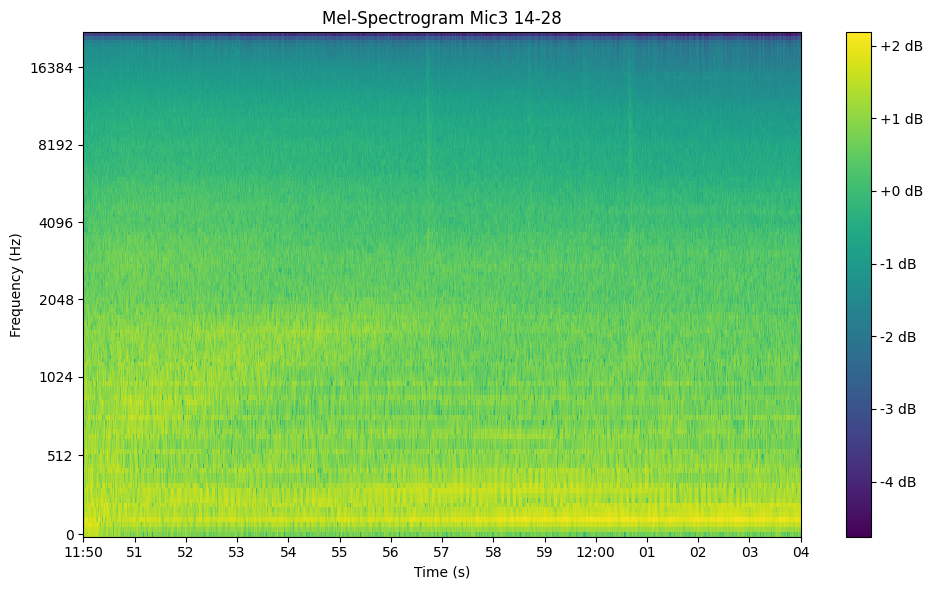

In [27]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Mic3 14-28', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([710, 724])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_8.png')
plt.show()

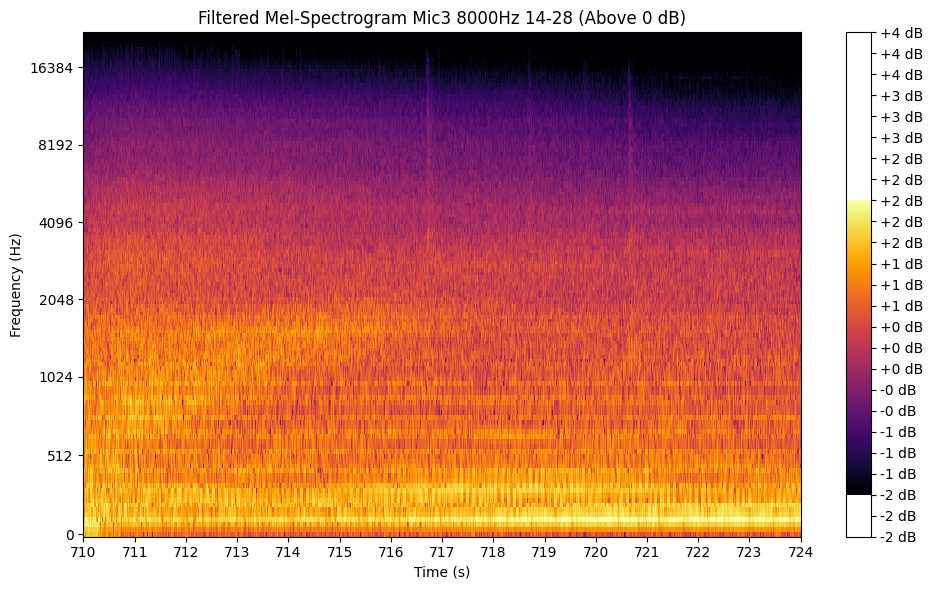

In [28]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='inferno', ax=ax, vmin=-1.5, vmax=2)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram Mic3 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([710, 724])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}"))

# Set color bar for dB scale
cbar = fig.colorbar(img2, ax=ax, format='%+2.0f dB')
cbar.set_ticks([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4])  # Add more tick marks for finer color gradation


# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_4_8000_filtered.png')
plt.show()

In [29]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_knock_highHZ = librosa.feature.melspectrogram(S=np.abs(stft_knock), sr=sr1,fmin=2500 , n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_knock_highHZ = librosa.power_to_db(mel_knock_highHZ, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_knock_highHZ = (mel_db_knock_highHZ - np.mean(mel_db_knock_highHZ)) / np.std(mel_db_knock_highHZ)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_knock.npy", mel_db_knock_highHZ)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


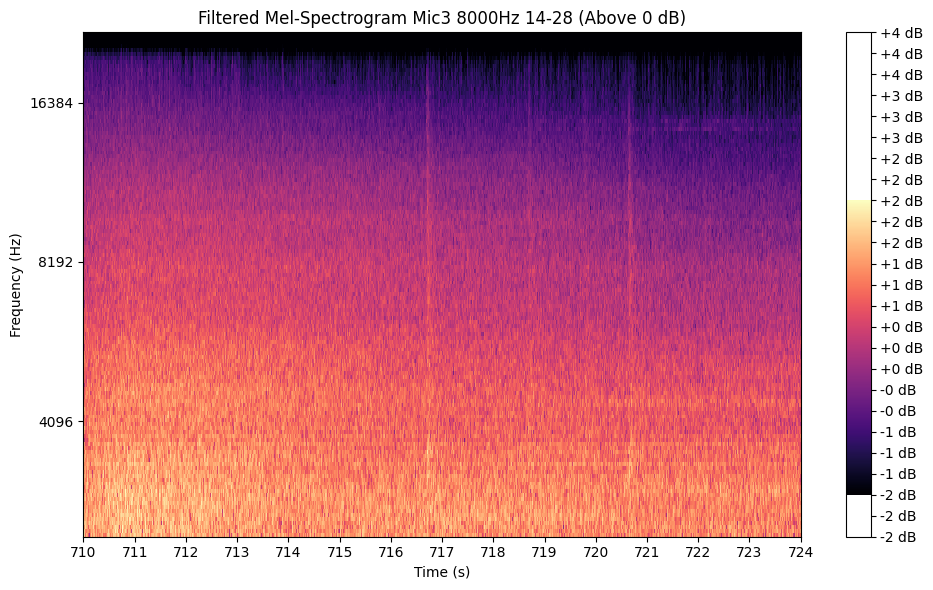

In [30]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock_highHZ, sr=sr1, x_axis='time', y_axis='mel', cmap='magma', ax=ax, fmin=2500, vmin=-1.5, vmax=2)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram Mic3 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([710, 724])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}"))

# Set color bar for dB scale
cbar = fig.colorbar(img2, ax=ax, format='%+2.0f dB')
cbar.set_ticks([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4])  # Add more tick marks for finer color gradation


# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_4_8000_filtered.png')
plt.show()